# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Explore the data

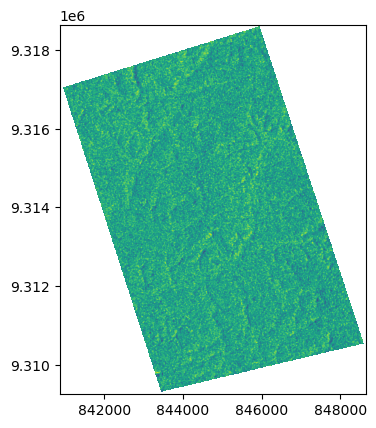

cordinate system EPSG:32720


In [2]:
# Directories
non_forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\non_forest"
forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\forest"

directory = forest_dir
tif_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]

sardat = rasterio.open(tif_files[40])
show(sardat)
print(f'cordinate system {sardat.crs}')

# Data Loading and Preprocessing

In [3]:
def load_tif_files(directory):
    """
    Load and return a list of arrays representing TIFF files from a directory.
    Each array will have a shape of (3, h, w) corresponding to the bands.
    """
    tif_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]
    bands_list = []
    
    for file_path in tif_files:
        with rasterio.open(file_path) as src:
            bands = src.read()  # shape (3, h, w)
            bands_list.append(bands)
    
    return bands_list

# Directories
non_forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\non_forest"
forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\forest"

# Load all non-forest and forest files
non_forest_data = load_tif_files(non_forest_dir)
forest_data = load_tif_files(forest_dir)

print(f"Loaded {len(non_forest_data)} non-forest files and {len(forest_data)} forest files.")

Loaded 31 non-forest files and 45 forest files.


#### Preparing Features and Labels -  Using tiles

In [4]:
def extract_features_from_tile(tile):
    """
    Extract statistical features from a tile.
    """
    tile_features = []
    for band in range(tile.shape[0]):
        band_data = tile[band]
        tile_features.extend([
            band_data.mean(),  # Mean
            band_data.std(),   # Standard deviation
            band_data.min(),   # Min value
            band_data.max(),   # Max value
            np.median(band_data)  # Median
        ])
    return tile_features

def tile_image(image_data, tile_size=8):
    """
    Divide an image into tiles, filtering out any tiles that contain NaN values,
    and compute statistical features for each valid tile.
    """
    h, w = image_data.shape[1], image_data.shape[2]
    tiles = []

    for i in range(0, h, tile_size):
        for j in range(0, w, tile_size):
            tile = image_data[:, i:i+tile_size, j:j+tile_size]
            if tile.shape[1] == tile_size and tile.shape[2] == tile_size:
                if not np.isnan(tile).any():  # Ensure the tile has no NaN values
                    tile_features = extract_features_from_tile(tile)
                    tiles.append(tile_features)
    
    return np.array(tiles)

# Apply tiling and feature extraction to all non-forest and forest images
non_forest_tiles = np.vstack([tile_image(bands, tile_size=8) for bands in non_forest_data])
forest_tiles = np.vstack([tile_image(bands, tile_size=8) for bands in forest_data])

# Combine and label tiles
X = np.vstack([non_forest_tiles, forest_tiles])
y = np.hstack([np.zeros(non_forest_tiles.shape[0]), np.ones(forest_tiles.shape[0])])

print(f"Tile feature matrix shape: {X.shape}, Labels shape: {y.shape}")  ## 15 features, 5 for each band


Tile feature matrix shape: (316730, 15), Labels shape: (316730,)


In [5]:
# Split the data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 221711 samples
Validation set size: 47509 samples
Test set size: 47510 samples


In [6]:
X_train.shape

(221711, 15)

# Classification Method 1: Random Forest

In [7]:
# Train the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators = 1, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1, random_state=42)

In [8]:
# Validate the model
val_predictions = rf_classifier.predict(X_val)
val_accuracy = (val_predictions == y_val).mean()
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Detailed performance report
print("Classification Report (Validation Set):")
print(classification_report(y_val, val_predictions, target_names=['Non-Forest', 'Forest']))

Validation Accuracy: 0.9964
Classification Report (Validation Set):
              precision    recall  f1-score   support

  Non-Forest       0.96      0.96      0.96      2044
      Forest       1.00      1.00      1.00     45465

    accuracy                           1.00     47509
   macro avg       0.98      0.98      0.98     47509
weighted avg       1.00      1.00      1.00     47509



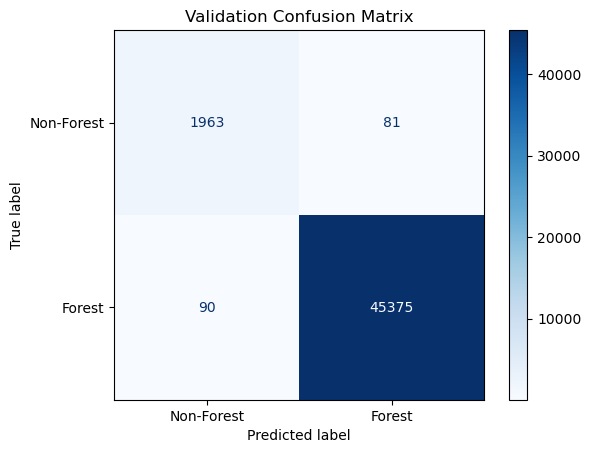

In [9]:
# Generate the confusion matrix for the validation set
val_conf_matrix = confusion_matrix(y_val, val_predictions)

# Plot the confusion matrix for the validation set
disp_val = ConfusionMatrixDisplay(confusion_matrix=val_conf_matrix, display_labels=['Non-Forest', 'Forest'])
disp_val.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

# Classification Method 2: SVM

In [ ]:
# Train the SVM model
svm_classifier = SVC(probability=True, random_state=42)
svm_classifier.fit(X_train, y_train)

In [ ]:
# Validate the SVM model
svm_val_predictions = svm_classifier.predict(X_val)
svm_val_accuracy = (svm_val_predictions == y_val).mean()
print(f"SVM Validation Accuracy: {svm_val_accuracy:.4f}")

# Evaluate the SVM model on the test set
svm_test_predictions = svm_classifier.predict(X_test)
svm_test_accuracy = (svm_test_predictions == y_test).mean()
print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")

# Generate and plot the confusion matrix for the test set
svm_test_conf_matrix = confusion_matrix(y_test, svm_test_predictions)
print("SVM Test Confusion Matrix:")
print(svm_test_conf_matrix)
disp_svm_test = ConfusionMatrixDisplay(confusion_matrix=svm_test_conf_matrix, display_labels=['Non-Forest', 'Forest'])
disp_svm_test.plot(cmap=plt.cm.Blues)
plt.title("SVM Test Confusion Matrix")
plt.show()

# Detailed performance report
print("SVM Classification Report (Test Set):")
print(classification_report(y_test, svm_test_predictions, target_names=['Non-Forest', 'Forest']))

# Classification Method 3: Decision Tree

In [ ]:
# Train the Decision Tree model
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train, y_train)

# Validate the Decision Tree model
tree_val_predictions = tree_classifier.predict(X_val)
tree_val_accuracy = (tree_val_predictions == y_val).mean()
print(f"Decision Tree Validation Accuracy: {tree_val_accuracy:.4f}")

# Evaluate the Decision Tree model on the test set
tree_test_predictions = tree_classifier.predict(X_test)
tree_test_accuracy = (tree_test_predictions == y_test).mean()
print(f"Decision Tree Test Accuracy: {tree_test_accuracy:.4f}")

# Generate and plot the confusion matrix for the test set
tree_test_conf_matrix = confusion_matrix(y_test, tree_test_predictions)
print("Decision Tree Test Confusion Matrix:")
print(tree_test_conf_matrix)
disp_tree_test = ConfusionMatrixDisplay(confusion_matrix=tree_test_conf_matrix, display_labels=['Non-Forest', 'Forest'])
disp_tree_test.plot(cmap=plt.cm.Blues)
plt.title("Decision Tree Test Confusion Matrix")
plt.show()

# Detailed performance report
print("Decision Tree Classification Report (Test Set):")
print(classification_report(y_test, tree_test_predictions, target_names=['Non-Forest', 'Forest']))


# RF vs. SVM

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Random Forest Test Evaluation
rf_test_predictions = rf_classifier.predict(X_test)
rf_test_accuracy = (rf_test_predictions == y_test).mean()
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.4f}")
rf_test_conf_matrix = confusion_matrix(y_test, rf_test_predictions)
disp_rf_test = ConfusionMatrixDisplay(confusion_matrix=rf_test_conf_matrix, display_labels=['Non-Forest', 'Forest'])
disp_rf_test.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Test Confusion Matrix")
plt.show()
print("Random Forest Classification Report (Test Set):")
print(classification_report(y_test, rf_test_predictions, target_names=['Non-Forest', 'Forest']))

# SVM Test Evaluation
svm_test_predictions = svm_classifier.predict(X_test)
svm_test_accuracy = (svm_test_predictions == y_test).mean()
print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")
svm_test_conf_matrix = confusion_matrix(y_test, svm_test_predictions)
disp_svm_test = ConfusionMatrixDisplay(confusion_matrix=svm_test_conf_matrix, display_labels=['Non-Forest', 'Forest'])
disp_svm_test.plot(cmap=plt.cm.Blues)
plt.title("SVM Test Confusion Matrix")
plt.show()
print("SVM Classification Report (Test Set):")
print(classification_report(y_test, svm_test_predictions, target_names=['Non-Forest', 'Forest']))

# Decision Tree Test Evaluation
tree_test_predictions = tree_classifier.predict(X_test)
tree_test_accuracy = (tree_test_predictions == y_test).mean()
print(f"Decision Tree Test Accuracy: {tree_test_accuracy:.4f}")
tree_test_conf_matrix = confusion_matrix(y_test, tree_test_predictions)
disp_tree_test = ConfusionMatrixDisplay(confusion_matrix=tree_test_conf_matrix, display_labels=['Non-Forest', 'Forest'])
disp_tree_test.plot(cmap=plt.cm.Blues)
plt.title("Decision Tree Test Confusion Matrix")
plt.show()
print("Decision Tree Classification Report (Test Set):")
print(classification_report(y_test, tree_test_predictions, target_names=['Non-Forest', 'Forest']))
